In [ ]:
!pip3 install pyabc==0.10.10

In [ ]:
!unzip data.zip

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import pandas as pd
import numpy as np
import scipy as sp
import os
import tempfile

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.sampler import SingleCoreSampler

import TumorPatientData as TPD

from functools import partial
import multiprocessing
import time

from termcolor import colored

In [3]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "tumor.db"))

In [4]:
MTD2Sphere = False
data = TPD.load_data(MTD2Sphere)

In [5]:
data_fig = TPD.make_plot(data, MTD2Sphere)
data_fig.show()

## Data groups
* 0-2: PCV
* 3-5: TMZ
* 6-8: RT

In [6]:
data[0]

,0,1,2,3,4,5,6,7,8,9
0,-84.159159,34.509202,-77.277277,33.231084,-73.853715,31.550595,-10.856690,47.675008,-14.332388,34.213342
1,-43.493493,40.047716,-40.617353,35.988506,-69.943555,32.881968,5.652875,44.420539,-12.811770,36.580228
2,-31.606607,43.456033,-3.688063,46.195704,-63.209390,36.876089,16.514431,41.166070,-8.684379,38.207462
3,-24.099099,47.290389,6.304568,40.426418,-49.741061,40.130557,28.027680,45.456052,-2.819139,41.905722
4,-12.212212,54.959100,20.859053,33.029899,-37.358887,42.201583,33.892921,48.414660,0.222097,40.574349
5,-4.704705,56.663258,33.023996,30.367151,-15.201312,48.858451,NaN,NaN,3.915026,39.242975
6,3.741241,53.254942,47.578481,29.479569,-6.077605,49.450172,NaN,NaN,10.431960,39.390905
7,7.807808,46.225290,57.353882,33.473690,3.915026,48.266729,NaN,NaN,21.945209,43.385026
8,21.571572,38.343558,69.736055,32.586107,10.214729,43.532957,NaN,NaN,27.593218,40.278488
9,33.458458,36.426380,81.032074,32.881968,16.948893,44.124678,NaN,NaN,35.196307,42.497444


# Model
<img src="ODE_cycle.jpg" width="600">

## Czynniki
**P** - proliferative tissue, tumor tissue <br>
rozrastająca się tkanka rakowa

**Q** - non-proliferative tissue <br>
tkanka rakowa wyciszona

**QP** - DNA-damaged Q tissue by the drug impact <br>
tkanka rakowa wyciszona z uszkodzonym DNA

**C** - drug concentration <br>
obecna ilość leku w organiźmie (max 1)


## Parametry
**KDE** - constant rate of the decay of the drug concentration <br>
tempo zanikania wpływu leku

**lambda_P** - growth rate of P

**gamma_P** - damages in P tissue caused by the drug

**gamma_Q** - damages in Q tissue caused by the drug <br>
autorzy zakładają: gamma_P = gamma_Q

**k_QP_P** - constant rate of transfer from QP to P tissue 

**delta_QP** - constant rate of elimination of QP tissue

**k_P_Q** - constant rate of transfer from P to Q tissue

**K** - maximal tumor size

# Individual Model

In [7]:
def individual_eq(t, y, KDE, lambda_P, gamma_P, gamma_Q, k_QP_P, delta_QP, k_P_Q, K, t_rise):
    P_sum, C, P, Q, QP = y
    
    if t < -t_rise:
        dC = 0
        C = 0
    elif -t_rise <= t < 0:
        dC = 1/t_rise
    else:
        dC = -KDE * C
    
    dP = lambda_P * P * (1 - P_sum/K) + k_QP_P * QP - k_P_Q * P - gamma_P * C * KDE * P
    dQ = k_P_Q * P - gamma_Q * C * KDE * Q
    dQP = gamma_Q * C * KDE * Q - k_QP_P * QP - delta_QP * QP

    dP_sum = dP+ dQ + dQP

    return dP_sum, dC, dP, dQ, dQP

In [8]:
def individual_model(t, y0, pars):
    t_rise =  (t[-1] - t[0])/20
    t_rise_up = min(t_rise, t[-1])
    t_rise_down = max(-t_rise, t[0])
    t_eval = np.unique(np.hstack([np.linspace(t[0], t[-1], 1000), np.linspace(t_rise_down, t_rise_up, 100), t]))
    sol = sp.integrate.solve_ivp(fun=individual_eq, 
                                 t_span=(t[0], t[-1]),
                                 t_eval=t_eval, 
                                 y0=y0,
                                 args=(
                                    pars["KDE"], pars["lambda_P"], pars["gamma_P"],
                                    pars["gamma_Q"], pars["k_QP_P"], pars["delta_QP"],
                                    pars["k_P_Q"], pars["K"], t_rise
                                 ),
#                                 method="BDF",
#                                 atol=1e-5
                                )
    return {"P_sum": sol.y[0, :], "dC": sol.y[1, :], "t": sol.t}

## PCV

In [9]:
KDE_art = 0.1
lambda_P_art = 0.121
gamma_P_art = 0.3
gamma_Q_art = gamma_P_art
k_QP_P_art = 0.05
delta_QP_art = 0.01
k_P_Q_art = 0.1
K_art = 100

In [10]:
group_n = 0  #groups for PCV: 0, 1, 2
# patient_n = 1
patient_n = 2

PCV_ind_patient_data = np.array(data[group_n][patient_n*2+1][data[group_n][patient_n*2+1].notnull()])
PCV_ind_patient_time = data[group_n][patient_n*2][data[group_n][patient_n*2].notnull()]
PCV_ind_patient_time = np.array([round(t) for t in PCV_ind_patient_time])

In [11]:
P_SUM_0 = PCV_ind_patient_data[0]
C_0 = 0
QP_0 = 0
P_0 = P_SUM_0 / 5
Q_0 = P_SUM_0 - P_0 - QP_0

In [12]:
PCV_art_ind_y0 = np.array([P_SUM_0, C_0, P_0, Q_0, QP_0])
PCV_art_ind_model = individual_model(pars={
    "KDE": KDE_art,
    "lambda_P": lambda_P_art,
    "gamma_P": gamma_P_art, 
    "gamma_Q": gamma_Q_art,
    "k_QP_P": k_QP_P_art,
    "delta_QP": delta_QP_art,
    "k_P_Q": k_P_Q_art,
    "K": K_art},
    t=PCV_ind_patient_time,
    y0=PCV_art_ind_y0
)

In [13]:
PCV_art_ind_model

{'P_sum': array([31.55059456, 31.6007572 , 31.65080015, ..., 48.84985054,
        48.86934726, 48.88889812]),
 'dC': array([0.        , 0.        , 0.        , ..., 0.09829543, 0.09735553,
        0.09642452]),
 't': array([-74.        , -73.9039039 , -73.80780781, ...,  21.80780781,
         21.9039039 ,  22.        ])}

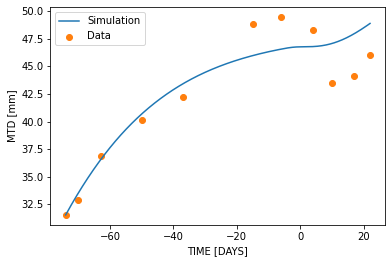

In [14]:
plt.plot(PCV_art_ind_model['t'], PCV_art_ind_model['P_sum'], color="C0", label='Simulation')
plt.scatter(PCV_ind_patient_time, PCV_ind_patient_data, color="C1", label='Data')
plt.xlabel("TIME [DAYS]")
plt.ylabel("MTD [mm]")
plt.legend()
plt.show()

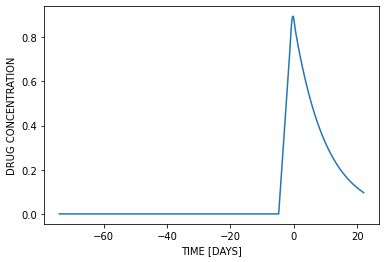

In [15]:
plt.plot(PCV_art_ind_model['t'], PCV_art_ind_model['dC'], color="C0", label='Simulation')
plt.xlabel("TIME [DAYS]")
plt.ylabel("DRUG CONCENTRATION")
plt.show()

### Asymilacja modelu indywidualnego do wybranego pacjenta



In [16]:
def get_simulation_time_indices(simulation_t, data_t):
    indices = []
    for t in data_t:
        found = np.where(simulation_t == t)[0]
        if found.shape[0] > 0:
            found = found[0]
            indices.append(found)
    return indices


def distance(simulation, measurement):
    simulation_t = simulation['t']
    measurement_t = measurement['t']
    
    sim_ind = get_simulation_time_indices(simulation_t, measurement_t)
    
    simulation_t = np.take(simulation_t, sim_ind)
    if simulation_t.shape != measurement_t.shape:
        print("simulation and measurement times shapes unequal")

    measurement_data = measurement['P_sum']
    simulation_data = np.take(simulation['P_sum'], sim_ind)

    #L1
    # diff = np.abs(simulation_data - measurement_data)

    #L2
    diff = np.sqrt(np.square(simulation_data - measurement_data))

    dist = np.mean(diff)
    return dist


def get_posterior(history):
    return history.get_distribution()[0].tail(1).values[0]

def show_art_abc_posterior(history):
    (K_ind_abc, KDE_ind_abc,
    delta_QP_ind_abc, gamma_P_ind_abc, 
    gamma_Q_ind_abc, k_P_Q_ind_abc, 
    k_QP_P_ind_abc, lambda_P_ind_abc) = get_posterior(h)
    
    print(
    f"""
    \t\tARTICLE: \t ABC-SMC
    K: \t\t {K_art} \t\t {K_ind_abc}
    KDE: \t {KDE_art} \t\t {KDE_ind_abc}
    delta_QP: \t {delta_QP_art} \t\t {delta_QP_ind_abc}
    gamma_P: \t {gamma_P_art} \t\t {gamma_P_ind_abc}
    gamma_Q: \t {gamma_Q_art} \t\t {gamma_Q_ind_abc}
    k_P_Q: \t {k_P_Q_art} \t\t {k_P_Q_ind_abc}
    k_QP_P: \t {k_QP_P_art} \t\t {k_QP_P_ind_abc}
    lambda_P: \t {lambda_P_art} \t\t {lambda_P_ind_abc}
    """)

def show_article_comparison(art, abc, group_name):
    (K_abc, KDE_abc,
    delta_QP_abc, gamma_P_abc, 
    gamma_Q_abc, k_P_Q_abc, 
    k_QP_P_abc, lambda_P_abc) = abc

    (K_art, KDE_art,
    delta_QP_art, gamma_P_art, 
    gamma_Q_art, k_P_Q_art, 
    k_QP_P_art, lambda_P_art) = art

    print(
    f"""
    \tGROUP: {colored(group_name,attrs=['bold'])}

    \t\tARTICLE: \t ABC-SMC
    K: \t\t {K_art} \t\t {K_abc}
    KDE: \t {KDE_art} \t\t {KDE_abc}
    delta_QP: \t {delta_QP_art} \t\t {delta_QP_abc}
    gamma_P: \t {gamma_P_art} \t\t {gamma_P_abc}
    gamma_Q: \t {gamma_Q_art} \t\t {gamma_Q_abc}
    k_P_Q: \t {k_P_Q_art} \t\t {k_P_Q_abc}
    k_QP_P: \t {k_QP_P_art} \t\t {k_QP_P_abc}
    lambda_P: \t {lambda_P_art} \t\t {lambda_P_abc}
    """)

In [17]:
distance(PCV_art_ind_model, {'P_sum':PCV_ind_patient_data, 't': PCV_ind_patient_time})

1.840012722479321

In [18]:
parameter_prior = Distribution(
    KDE=RV("uniform", 0.0, 0.5),
    lambda_P=RV("uniform", 0.0, 1),
    gamma_P=RV("uniform", 0.0, 1),
    gamma_Q=RV("uniform", 0.0, 1),
    k_QP_P=RV("uniform", 0.0, 0.5),
    delta_QP=RV("uniform", 0.0, 0.5),
    k_P_Q=RV("uniform", 0.0, 1),
    K=RV("uniform", 10, 200)
)

# parameter_prior = Distribution(
#     KDE=RV("uniform", 0, 0.5),
#     lambda_P=RV("uniform", 0, 0.5),
#     gamma_P=RV("uniform", 0, 0.5),
#     gamma_Q=RV("uniform", 0, 0.5),
#     k_QP_P=RV("uniform", 0, 0.2),
#     delta_QP=RV("uniform", 0, 0.2),
#     k_P_Q=RV("uniform", 0, 0.5),
#     K=RV("uniform", 10, 200)
# )

# window=0.5
# parameter_prior = Distribution(
#     KDE=RV("uniform", KDE_art-window, KDE_art+window),
#     lambda_P=RV("uniform", lambda_P_art-window, lambda_P_art+window),
#     gamma_P=RV("uniform", gamma_P_art-window, gamma_P_art+window),
#     gamma_Q=RV("uniform", gamma_Q_art-window, gamma_Q_art+window),
#     k_QP_P=RV("uniform", k_QP_P_art-window, k_QP_P_art+window),
#     delta_QP=RV("uniform", delta_QP_art-window, delta_QP_art+window),
#     k_P_Q=RV("uniform", k_P_Q_art-window, k_P_Q_art+window),
#     K=RV("uniform", K_art-window, K_art+window)
# )

parameter_prior.get_parameter_names()

['K', 'KDE', 'delta_QP', 'gamma_P', 'gamma_Q', 'k_P_Q', 'k_QP_P', 'lambda_P']

In [19]:
ind_model = lambda pars: individual_model(t=PCV_ind_patient_time, y0=PCV_art_ind_y0, pars=pars)
PCV_ind_abc = ABCSMC(
    models=ind_model,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=10,
    transitions=LocalTransition(k_fraction=.3),
    # transitions=LocalTransition(k_fraction=.2),
    eps=MedianEpsilon(20, median_multiplier=0.7)
#     sampler=SingleCoreSampler
)

INFO:Sampler:Parallelizing the sampling on 2 cores.


In [20]:
PCV_ind_abc.new(db_path, {'P_sum': PCV_ind_patient_data, 't': PCV_ind_patient_time});

INFO:History:Start <ABCSMC(id=1, start_time=2021-01-24 14:09:46.529268, end_time=None)>


In [21]:
h = PCV_ind_abc.run(minimum_epsilon=5, max_nr_populations=5)

INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 17 = 5.8824e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 7.179901038453482.
INFO:ABC:Acceptance rate: 10 / 47 = 2.1277e-01, ESS=5.8577e+00.
INFO:ABC:t: 2, eps: 3.6648033173887677.
INFO:ABC:Acceptance rate: 10 / 90 = 1.1111e-01, ESS=3.4486e+00.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-24 14:09:46.529268, end_time=2021-01-24 14:09:50.535497)>


In [22]:
(K_ind_abc, KDE_ind_abc,
delta_QP_ind_abc, gamma_P_ind_abc, 
gamma_Q_ind_abc, k_P_Q_ind_abc, 
k_QP_P_ind_abc, lambda_P_ind_abc) = get_posterior(h)

In [23]:
PCV_abc_ind_model = individual_model(pars={
    "KDE": KDE_ind_abc,
    "lambda_P": lambda_P_ind_abc,
    "gamma_P": gamma_P_ind_abc, 
    "gamma_Q": gamma_Q_ind_abc,
    "k_QP_P": k_QP_P_ind_abc,
    "delta_QP": delta_QP_ind_abc,
    "k_P_Q": k_P_Q_ind_abc,
    "K": K_ind_abc},
    t=PCV_ind_patient_time,
    y0=PCV_art_ind_y0
)

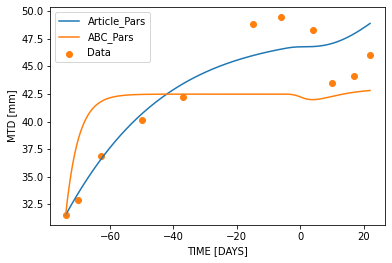

In [24]:
plt.plot(PCV_art_ind_model['t'], PCV_art_ind_model['P_sum'], color="C0", label='Article_Pars')
plt.plot(PCV_abc_ind_model['t'], PCV_abc_ind_model['P_sum'], color="C1", label='ABC_Pars')
plt.scatter(PCV_ind_patient_time, PCV_ind_patient_data, color="C1", label='Data')
plt.xlabel("TIME [DAYS]")
plt.ylabel("MTD [mm]")
plt.legend()
plt.show()

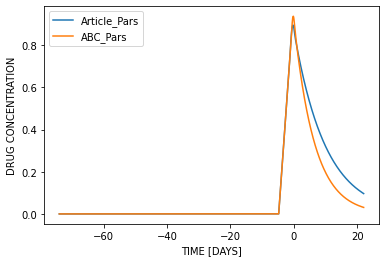

In [25]:
plt.plot(PCV_art_ind_model['t'], PCV_art_ind_model['dC'], color="C0", label='Article_Pars')
plt.plot(PCV_abc_ind_model['t'], PCV_abc_ind_model['dC'], color="C1", label='ABC_Pars')
plt.xlabel("TIME [DAYS]")
plt.ylabel("DRUG CONCENTRATION")
plt.legend()
plt.show()

In [26]:
show_art_abc_posterior(h)


    		ARTICLE: 	 ABC-SMC
    K: 		 100 		 133.73619114000675
    KDE: 	 0.1 		 0.15419118158611494
    delta_QP: 	 0.01 		 0.3414134886818899
    gamma_P: 	 0.3 		 0.8285267254085762
    gamma_Q: 	 0.3 		 0.08153983628574267
    k_P_Q: 	 0.1 		 0.6293609907101774
    k_QP_P: 	 0.05 		 0.3675125274849862
    lambda_P: 	 0.121 		 0.552701496553722
    


### Asymilacja modelu indywidualnego do wszystkich pacjentów PCV

In [27]:
def get_data_for_groups(groups):
    measurements = []
    times = []
    for group_n in groups:
        group_data = data[group_n]
        for patient_n in range(int(group_data.shape[1]/2)):
            ind_patient_data = data[group_n][patient_n*2+1][data[group_n][patient_n*2+1].notnull()].values
            ind_patient_time = data[group_n][patient_n*2][data[group_n][patient_n*2].notnull()].values
            measurements.append(ind_patient_data)   
            times.append(ind_patient_time)
    return measurements, times

def train_ind_model(measurement, time):
    P_SUM_0 = measurement[0]
    C_0 = 0
    QP_0 = 0
    P_0 = P_SUM_0 / 5
    Q_0 = P_SUM_0 - P_0 - QP_0

    y0 = np.array([P_SUM_0, C_0, P_0, Q_0, QP_0])

    parameter_prior = Distribution(
        KDE=RV("uniform", 0.0, 1),
        lambda_P=RV("uniform", 0.0, 1),
        gamma_P=RV("uniform", 0.0, 1),
        gamma_Q=RV("uniform", 0.0, 1),
        k_QP_P=RV("uniform", 0.0, 0.5),
        delta_QP=RV("uniform", 0.0, 1),
        k_P_Q=RV("uniform", 0.0, 1),
        K=RV("uniform", 10, 200)
    )

    ind_model = lambda pars: individual_model(t=time, y0=y0, pars=pars)
    ind_abc = ABCSMC(
        models=ind_model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=10,
        transitions=LocalTransition(k_fraction=.3),
        eps=MedianEpsilon(20, median_multiplier=0.7)
    )

    ind_abc.new(db_path, {'P_sum': measurement, 't': time})

    h = ind_abc.run(minimum_epsilon=5, max_nr_populations=3)
    return get_posterior(h)



In [28]:
TIMEOUT = 30

def worker(m, t, posteriors):
    post = train_ind_model(m, t)
    posteriors.append(post)

def get_mean_parameters_for_groups(groups):
    measurements, times = get_data_for_groups(groups)

    manager = multiprocessing.Manager()
    posteriors = manager.list()
    patient_spec = []

    for m, t in zip(measurements, times):
        p = multiprocessing.Process(target=worker, args=(m, t, posteriors))
        p.start()
        p.join(TIMEOUT)

        if p.is_alive():
            p.terminate()
            p.join()
            print('\n\nKILLED\n\n')
        else:
            p.join()
            patient_spec.append((m, t, posteriors[-1]))
    return np.mean(posteriors, axis=0), np.std(posteriors, axis=0), patient_spec




In [31]:
PCV_groups = [0, 1, 2]
PCV_mean_parameters, PCV_std_parameters, PCV_patients_spec = get_mean_parameters_for_groups(PCV_groups)

INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=2, start_time=2021-01-24 14:10:18.703434, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 17 = 5.8824e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 9.21557275900925.
INFO:ABC:Acceptance rate: 10 / 33 = 3.0303e-01, ESS=4.1254e+00.
INFO:ABC:t: 2, eps: 5.165137291118664.
INFO:ABC:Acceptance rate: 10 / 450 = 2.2222e-02, ESS=1.5775e+00.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=2, start_time=2021-01-24 14:10:18.703434, end_time=2021-01-24 14:10:28.331265)>
INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=3, start_time=2021-01-24 14:10:28.429878, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 18 = 5.5556e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 7.169847829417063.
INFO:ABC:Acceptance rate: 10 / 43 = 2.3256e-01, ESS=5.6518e+00.
INFO:ABC:t: 2, eps: 3.0641970646772214.




KILLED




INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=4, start_time=2021-01-24 14:10:58.576634, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 14 = 7.1429e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 4.855171438929135.
INFO:ABC:Acceptance rate: 10 / 65 = 1.5385e-01, ESS=3.2294e+00.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=4, start_time=2021-01-24 14:10:58.576634, end_time=2021-01-24 14:11:02.997376)>
INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=5, start_time=2021-01-24 14:11:03.090975, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 19 = 5.2632e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 3.1771874388654227.
INFO:ABC:Acceptance rate: 10 / 41 = 2.4390e-01, ESS=5.9044e+00.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=5, start_time=2021-01-24 14:11:03.090975, end_time=2021-01-24 14:11:04.563791)>
INFO:Sampler:Parallelizing the sa



KILLED




INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=8, start_time=2021-01-24 14:11:38.958351, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 30 = 3.3333e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 10.464812175129305.
INFO:ABC:Acceptance rate: 10 / 66 = 1.5152e-01, ESS=5.0144e+00.
INFO:ABC:t: 2, eps: 6.589935467225761.
INFO:ABC:Acceptance rate: 10 / 93 = 1.0753e-01, ESS=4.0976e+00.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=8, start_time=2021-01-24 14:11:38.958351, end_time=2021-01-24 14:11:46.881762)>
INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=9, start_time=2021-01-24 14:11:47.120479, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 20 = 5.0000e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 4.079816343668686.




KILLED




INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=10, start_time=2021-01-24 14:12:17.255612, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 16 = 6.2500e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 11.893451047244342.
INFO:ABC:Acceptance rate: 10 / 28 = 3.5714e-01, ESS=3.6850e+00.
INFO:ABC:t: 2, eps: 3.8210759709002615.
INFO:ABC:Acceptance rate: 10 / 73 = 1.3699e-01, ESS=3.0492e+00.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=10, start_time=2021-01-24 14:12:17.255612, end_time=2021-01-24 14:12:25.951146)>
INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=11, start_time=2021-01-24 14:12:26.283555, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 19 = 5.2632e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 10.342032231641513.
INFO:ABC:Acceptance rate: 10 / 80 = 1.2500e-01, ESS=3.2820e+00.
INFO:ABC:t: 2, eps: 4.480868844284641.




KILLED




INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=12, start_time=2021-01-24 14:12:56.392712, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 24 = 4.1667e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 11.300546440583085.
INFO:ABC:Acceptance rate: 10 / 17 = 5.8824e-01, ESS=1.9457e+00.
INFO:ABC:t: 2, eps: 4.764866923653946.
INFO:ABC:Acceptance rate: 10 / 124 = 8.0645e-02, ESS=1.6825e+00.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=12, start_time=2021-01-24 14:12:56.392712, end_time=2021-01-24 14:13:09.109139)>
INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=13, start_time=2021-01-24 14:13:09.499497, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 28 = 3.5714e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 8.898442814150531.
INFO:ABC:Acceptance rate: 10 / 63 = 1.5873e-01, ESS=4.1936e+00.
INFO:ABC:t: 2, eps: 3.3864857506800425.
INFO:ABC:Acceptance rate



KILLED




INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=17, start_time=2021-01-24 14:14:22.324144, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 13 = 7.6923e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 7.444129600896876.
INFO:ABC:Acceptance rate: 10 / 55 = 1.8182e-01, ESS=5.0136e+00.
INFO:ABC:t: 2, eps: 2.8715515673987193.




KILLED




INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=18, start_time=2021-01-24 14:14:52.502719, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 17 = 5.8824e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 4.6047893340682355.
INFO:ABC:Acceptance rate: 10 / 70 = 1.4286e-01, ESS=6.9635e+00.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=18, start_time=2021-01-24 14:14:52.502719, end_time=2021-01-24 14:15:03.840012)>
INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=19, start_time=2021-01-24 14:15:04.474085, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 15 = 6.6667e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 9.8228610835317.
INFO:ABC:Acceptance rate: 10 / 41 = 2.4390e-01, ESS=2.5836e+00.
INFO:ABC:t: 2, eps: 6.809809453180968.




KILLED




INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=20, start_time=2021-01-24 14:15:34.547427, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 16 = 6.2500e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 7.639248342955346.
INFO:ABC:Acceptance rate: 10 / 65 = 1.5385e-01, ESS=4.1377e+00.
INFO:ABC:t: 2, eps: 4.957021730117438.




KILLED




In [32]:
PCV_art_pars = [K_art, KDE_art, delta_QP_art, gamma_P_art, gamma_Q_art, k_P_Q_art, k_QP_P_art, lambda_P_art]
show_article_comparison(PCV_art_pars, PCV_mean_parameters,'PCV')


    	GROUP: PCV

    		ARTICLE: 	 ABC-SMC
    K: 		 100 		 112.17668246313464
    KDE: 	 0.1 		 0.34687344886646515
    delta_QP: 	 0.01 		 0.5012976434252381
    gamma_P: 	 0.3 		 0.5705573878703301
    gamma_Q: 	 0.3 		 0.37539574034506046
    k_P_Q: 	 0.1 		 0.5387590673619109
    k_QP_P: 	 0.05 		 0.2848654403419156
    lambda_P: 	 0.121 		 0.5511237721989762
    


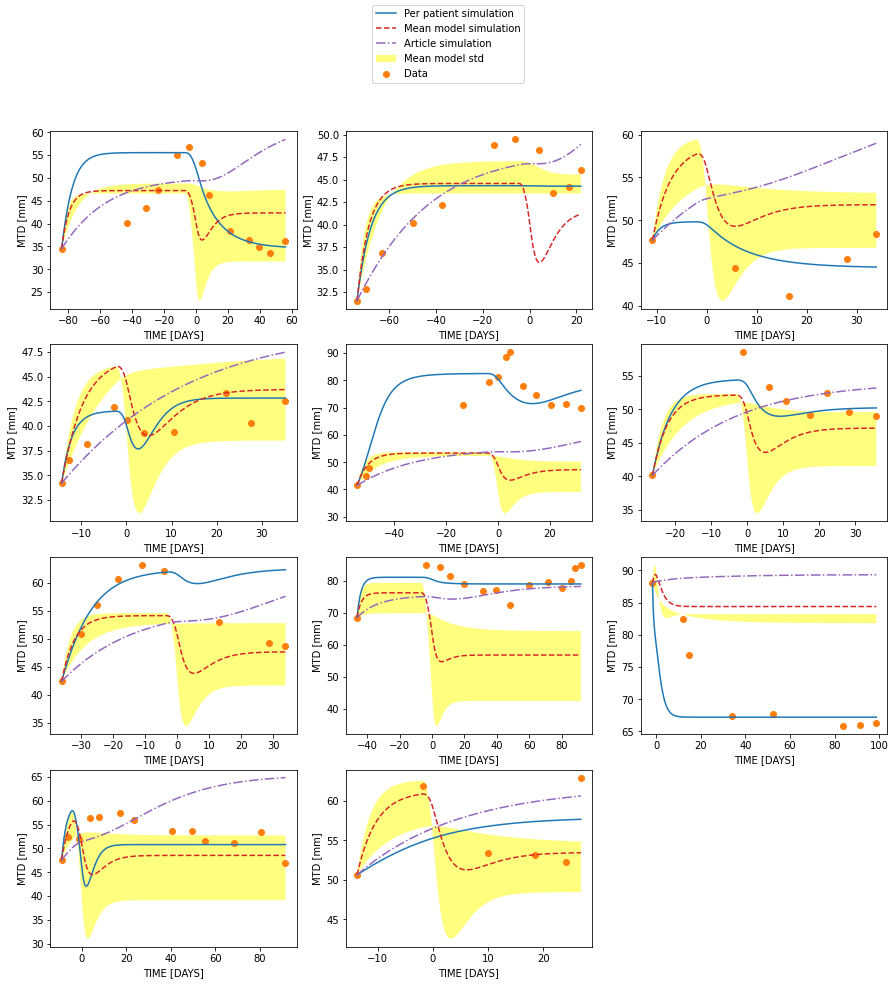

In [81]:
fig, axs = plt.subplots(4, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

i, j = 0, 0

for patient_spec in PCV_patients_spec:

  mean_spec = PCV_mean_parameters
  mean_spec_minus_std = PCV_mean_parameters - PCV_std_parameters
  mean_spec_plus_std = PCV_mean_parameters + PCV_std_parameters
  art_spec = PCV_art_pars

  P_SUM_0 = patient_spec[0][0]
  C_0 = 0
  QP_0 = 0
  P_0 = P_SUM_0 / 5
  Q_0 = P_SUM_0 - P_0 - QP_0

  PCV_ind_y0 = np.array([P_SUM_0, C_0, P_0, Q_0, QP_0])

  PCV_ind_model = individual_model(pars={
      "KDE": patient_spec[2][1],
      "lambda_P": patient_spec[2][7],
      "gamma_P": patient_spec[2][3], 
      "gamma_Q": patient_spec[2][4],
      "k_QP_P": patient_spec[2][6],
      "delta_QP": patient_spec[2][2],
      "k_P_Q": patient_spec[2][5],
      "K": patient_spec[2][0]},
      t=patient_spec[1],
      y0=PCV_ind_y0
  )

  PCV_mean_model = individual_model(pars={
      "KDE": mean_spec[1],
      "lambda_P": mean_spec[7],
      "gamma_P": mean_spec[3], 
      "gamma_Q": mean_spec[4],
      "k_QP_P": mean_spec[6],
      "delta_QP": mean_spec[2],
      "k_P_Q": mean_spec[5],
      "K": mean_spec[0]},
      t=patient_spec[1],
      y0=PCV_ind_y0
  )

  PCV_mean_minus_std_model = individual_model(pars={
      "KDE": mean_spec_minus_std[1],
      "lambda_P": mean_spec_minus_std[7],
      "gamma_P": mean_spec_minus_std[3], 
      "gamma_Q": mean_spec_minus_std[4],
      "k_QP_P": mean_spec_minus_std[6],
      "delta_QP": mean_spec_minus_std[2],
      "k_P_Q": mean_spec_minus_std[5],
      "K": mean_spec_minus_std[0]},
      t=patient_spec[1],
      y0=PCV_ind_y0
  )
    
  PCV_mean_plus_std_model = individual_model(pars={
      "KDE": mean_spec_plus_std[1],
      "lambda_P": mean_spec_plus_std[7],
      "gamma_P": mean_spec_plus_std[3], 
      "gamma_Q": mean_spec_plus_std[4],
      "k_QP_P": mean_spec_plus_std[6],
      "delta_QP": mean_spec_plus_std[2],
      "k_P_Q": mean_spec_plus_std[5],
      "K": mean_spec_plus_std[0]},
      t=patient_spec[1],
      y0=PCV_ind_y0
  )

  PCV_art_model = individual_model(pars={
      "KDE": art_spec[1],
      "lambda_P": art_spec[7],
      "gamma_P": art_spec[3], 
      "gamma_Q": art_spec[4],
      "k_QP_P": art_spec[6],
      "delta_QP": art_spec[2],
      "k_P_Q": art_spec[5],
      "K": art_spec[0]},
      t=patient_spec[1],
      y0=PCV_ind_y0
  )

  axs[i, j].plot(PCV_ind_model['t'], PCV_ind_model['P_sum'], color="C0", label='Per patient simulation')
  
  axs[i, j].plot(PCV_mean_model['t'],  PCV_mean_model['P_sum'], color="C3", label='Mean model simulation', ls='--')
  
  axs[i, j].fill_between(PCV_mean_model['t'], PCV_mean_minus_std_model['P_sum'], PCV_mean_plus_std_model['P_sum'], 
                         facecolor='yellow', alpha=0.5,
                label='Mean model std')
  
  axs[i, j].plot(PCV_art_model['t'], PCV_art_model['P_sum'], color="C4", label='Article simulation', ls='-.')

  axs[i, j].scatter(patient_spec[1], patient_spec[0], color="C1", label='Data')

  j += 1
  if j == 3:
    j = 0
    i += 1
  if i == 4:
    i = 0

for ax in axs.flat:
    ax.set(xlabel='TIME [DAYS]', ylabel='MTD [mm]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
fig.delaxes(axs[-1, -1])
plt.show()

In [128]:
absolute_difference_function = lambda list_value : abs(list_value)
i = 0

for patient in PCV_patients_spec:
  time_values = list(patient[1])
  mtd_values = list(patient[0])
  max_tumor_time_index = time_values.index(min(patient[1], key=absolute_difference_function))
  max_tumor_mtd = max(patient[0])
  max_tumor_data_index = mtd_values.index(max_tumor_mtd)

  max_tumor_index = max_tumor_time_index

  if max_tumor_time_index > max_tumor_data_index:
    max_tumor_index = max_tumor_data_index

  max_tumor_mtd = patient[0][max_tumor_index]

  min_tumor_index = mtd_values.index(min(patient[0][max_tumor_index:-1]))
  min_tumor_mtd = patient[0][min_tumor_index]

  final_tumor_mtd = patient[0][-1]

  at_size_change = round(min_tumor_mtd - max_tumor_mtd,3)
  final_size_change = round(final_tumor_mtd - max_tumor_mtd,3)

  if at_size_change < 0:
    at_prop_size_change = round(abs(at_size_change)/max_tumor_mtd*100,3)
  else:
    at_prop_size_change = round(at_size_change/max_tumor_mtd*100 + 100,3)

  if final_size_change < 0:
    final_prop_size_change = round(abs(final_size_change)/max_tumor_mtd*100,3)
  else:
    final_prop_size_change = round(final_size_change/max_tumor_mtd*100 + 100,3)

  print('Patient ', i)
  print('   After treatment size change: ', at_size_change, ' mm')
  print('   Proporitonal size change: \t', at_prop_size_change, ' %')

  print('   Final size change: \t\t', final_size_change, ' mm')
  print('   Final size change: \t\t', final_prop_size_change, ' %', '\n')

  i += 1


Patient  0
   After treatment size change:  -23.219  mm
   Proporitonal size change: 	 40.977  %
   Final size change: 		 -20.45  mm
   Final size change: 		 36.09  % 

Patient  1
   After treatment size change:  -5.917  mm
   Proporitonal size change: 	 11.966  %
   Final size change: 		 -3.402  mm
   Final size change: 		 6.88  % 

Patient  2
   After treatment size change:  -3.254  mm
   Proporitonal size change: 	 7.325  %
   Final size change: 		 3.994  mm
   Final size change: 		 108.991  % 

Patient  3
   After treatment size change:  -1.331  mm
   Proporitonal size change: 	 3.28  %
   Final size change: 		 1.923  mm
   Final size change: 		 104.739  % 

Patient  4
   After treatment size change:  -10.344  mm
   Proporitonal size change: 	 12.725  %
   Final size change: 		 -11.396  mm
   Final size change: 		 14.019  % 

Patient  5
   After treatment size change:  -9.331  mm
   Proporitonal size change: 	 15.935  %
   Final size change: 		 -9.606  mm
   Final size change: 		 1